# Goal

We want to compare the performance of different numerical integration packages against one dimentional functions. We will model their quality by taking 2 exponentially distributed real numbers, and integrating test functions on their interval $[a, b], b>a$. If the test function has a singularity, we will have it at $ 0 $, to ensure that it is outside the integration interval, however it is still arbitrarely close to the integration interval, such as $\sin( x^{-1} )$

In [20]:
from dataclasses import dataclass
from typing import Callable

@dataclass
class TestFunction:
        name: str
        distribution: Callable[[float], float]
        cumulative: Callable[[float], float]
        
@dataclass
class IntegrationAlgorithm:
        name: str
        integral: Callable[[Callable[[float], float], float, float], float]

# Test functions

In [21]:
import math
test_functions = [
        TestFunction(name="sin", distribution=math.sin, cumulative=lambda x: - 1 * math.cos(x)),
        TestFunction(name="quadratic", distribution=lambda x: x**2, cumulative=lambda x: x**3/3),
        TestFunction(name="asymmetric", distribution=lambda x: x**(-11), cumulative=lambda x: -1 * x**(-10)/10)
]

# Integration algorithms

In [65]:
import scipy
integration_algorithms = [
        IntegrationAlgorithm(name="scipy_quad", integral=lambda fun, a, b: scipy.integrate.quad(fun, a, b)[0]),
        IntegrationAlgorithm(name="fixed_quad", integral=lambda fun, a, b: scipy.integrate.fixed_quad(lambda x: fun(x[0]), a, b)[0]),
        # IntegrationAlgorithm(name="scipy_qmc_quad", integral=lambda fun, a, b: scipy.integrate.qmc_quad(lambda (x,n): [fun(z) for z in x], [a], [b]).integral),
]

# Dataset creation

In [67]:
from itertools import product
from tqdm import tqdm
import pandas as pd
import numpy as np

df = pd.DataFrame(columns=["test_function", "integration_algorithm", "a", "b", "integral", "estimated_integral"])
n_samples = 10
iterator = product(
        test_functions,
        integration_algorithms,
        np.random.exponential(1, size=n_samples),
        np.random.exponential(1, size=n_samples)
)
for function, algorithm, lower_bound, upper_bound in tqdm(iterator, total=len(test_functions)* len(integration_algorithms)*n_samples**2):
        lower_bound,upper_bound = min(lower_bound, upper_bound), max(lower_bound, upper_bound)
        df.loc[len(df.index)] = [function.name, algorithm.name, lower_bound, upper_bound, function.cumulative(upper_bound) - function.cumulative(lower_bound), algorithm.integral(function.distribution, lower_bound, upper_bound)] 

100%|██████████| 600/600 [00:00<00:00, 2479.63it/s]


# Analysis of results

In [71]:
df["relative_error"] = (df["estimated_integral"] - df["integral"])/ df["integral"]


,test_function,integration_algorithm,a,b,integral,estimated_integral,relative_error
0,sin,scipy_quad,0.251466,0.836857,2.987488e-01,2.987488e-01,3.716243e-16
1,sin,scipy_quad,0.251466,2.002791,1.387231e+00,1.387231e+00,0.000000e+00
2,sin,scipy_quad,0.177883,0.251466,1.567187e-02,1.567187e-02,-2.877946e-15
3,sin,scipy_quad,0.251466,0.463737,7.416159e-02,7.416159e-02,-3.742581e-16
4,sin,scipy_quad,0.204424,0.251466,1.062946e-02,1.062946e-02,1.631996e-15
...,...,...,...,...,...,...,...
595,asymmetric,fixed_quad,0.911635,1.128563,2.223898e-01,5.311940e-01,1.388572e+00
596,asymmetric,fixed_quad,0.781501,0.911635,9.245770e-01,1.798841e+00,9.455829e-01
597,asymmetric,fixed_quad,0.179396,0.911635,2.896428e+06,1.720996e+07,4.941787e+00
598,asymmetric,fixed_quad,0.390083,0.911635,1.225588e+03,8.393957e+03,5.848925e+00


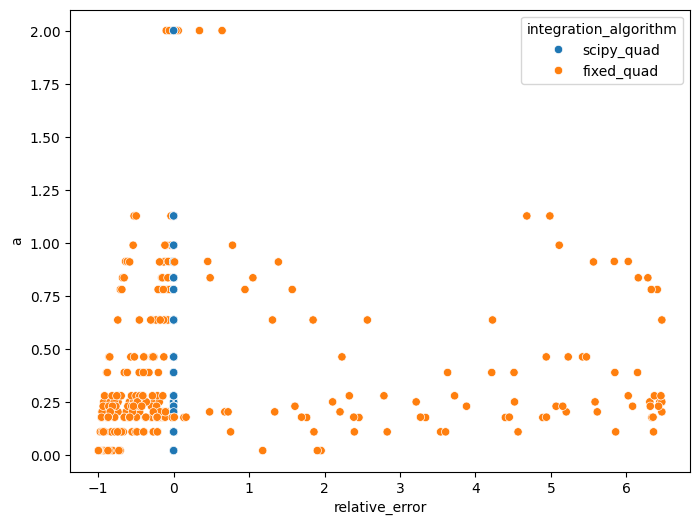

In [73]:
import seaborn as sns
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(x='relative_error', y='a', hue='integration_algorithm', data=df) 
plt.show()